In [1]:
import glob
general_path = '/Users/emilio/Documents/GitHub/lightning-template/'

ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
#split ob1_files.split('/')
patient_t=[]
sweep_t=[]
for i in range(len(ob1_files)):
    ob1_files[i]=ob1_files[i].split('/')[-1].split('.')[0]
    patient=ob1_files[i].split('_')[0]
    sweep=ob1_files[i].split('sweep')[1]
    #if sweep[0] is not a number, use sweep[1]
    sweep = sweep[1] if not sweep[0].isdigit() else sweep[0]
    patient_t.append(patient)
    sweep_t.append(sweep)
print(ob1_files)
print(patient_t)
print(sweep_t)

['007_sweep1', '002_sweep5', '016_sweep2', '011_sweep2 (1)', '007_sweep2', '002_sweep6', '007_sweep3', '016_sweep1', '007_sweep7', '002_sweep2', '002_sweep3', '007_sweep6', '016_sweep4', '004_sweep8', '016_sweep6', '007_sweep4', '002_sweep1', '016_sweep7', '011_sweep3 (1)', '008_sweep3', '014_sweep2', '014_sweep3', '005_sweep1', '013_sweep 1', '008_sweep2', '011_sweep6', '011_sweep4', '013_sweep 3', '005_sweep3', '014_sweep1', '011_sweep1 (1)', '005_sweep2', '013_sweep 2', '008_sweep1', '011_sweep5', '011_sweep1', '013_sweep 6', '005_sweep6', '014_sweep4', '014_sweep5', '013_sweep 7', '011_sweep2', '008_sweep6', '013_sweep 5', '005_sweep5', '014_sweep7', '014_sweep6', '005_sweep4', '013_sweep 4', '008_sweep7', '011_sweep3', '003_sweep2', '006_sweep7', '006_sweep6', '012_sweep1', '003_sweep3', '011_sweep5 (1)', '003_sweep1', '012_sweep3', '014_sweep8', '006_sweep4', '006_sweep5', '008_sweep8', '012_sweep2', '011_sweep4 (1)', '003_sweep4', '012_sweep6', '006_sweep1', '012_sweep7', '012_s

In [2]:


import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys



src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video

ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')

for i in range(len(ob1_files)):
     mp4_file_path = general_path+'./Study/'+patient_t[i]+'/'+patient_t[i]+'_sweep'+sweep_t[i]+'.mp4'
     ob = sio.loadmat(ob1_files[i])['labels']
     ob=np.moveaxis(ob, 2, 0)
     gt_video = skv.vread(mp4_file_path)
     diff = gt_video[1:,:,:,0]-gt_video[:-1,:,:,0]
     diff_sum = np.sum(diff,axis=(1,2))
     #normalize diff_sum
     diff_sum = diff_sum/np.max(diff_sum)

     # Assuming diff_sum is your normalized data array from the plot
     # Example: diff_sum = np.array([...])  # Replace with your actual array
     threshold = 0.2

     # Detect indices where diff_sum crosses above the threshold
     first_frame = np.where(diff_sum > threshold)[0][0]  # First upward crossing
     last_frame = np.where(diff_sum > threshold)[0][-1]  # Last upward crossing (before drop)


     # Obtener los límites del área de interés
     row_limits, col_limits = np.where(diff[first_frame+50] > 0)
     y1, y2 = row_limits.min(), row_limits.max()
     x1, x2 = col_limits.min(), col_limits.max()

     # Recortar el área de interés
     gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
     ob = ob[first_frame:last_frame, :,:]
     new_shape=gt_video.shape[1:]
     ob=np.array([resize(mask, new_shape, order=0, preserve_range=True, anti_aliasing=False) for mask in ob])
     ob=ob.astype(int)

     # Create a TorchIO subject with paired data
     subject = tio.Subject(
     video_gt=tio.ScalarImage(tensor=np.expand_dims(gt_video,axis=0)),  # Add channel dimension
     label=tio.LabelMap(tensor=np.expand_dims(ob,axis=0))  # Add channel dimension
     )

     #efine the resize transform
     resize_transform = tio.transforms.Resize((256, 512,512))  # New shape: [frames, width, height]

     # Apply the resize transform to the subject
     resized_subject = resize_transform(subject)


     # Extract resized video GT and label from the subject
     resized_video_gt = resized_subject.video_gt.tensor.squeeze(0).numpy()  # Remove channel dimension
     resized_label = resized_subject.label.tensor.squeeze(0).numpy().astype(int)  # Ensure integers for label

     num_classes = 6  # Número de clases
     # Crear la versión one-hot encoded
     one_hot = np.eye(num_classes)[resized_label]  # Esto genera el one-hot encoding
     # Verificar el nuevo shape
     print(one_hot.shape) 
     generate_overlay_video(resized_video_gt, one_hot, fps=15, output_video=general_path+'results/'+patient_t[i]+'_sweep'+sweep_t[i]+'_overlay.avi')
     break




(256, 512, 512, 6)
Video guardado como /Users/emilio/Documents/GitHub/lightning-template/results/007_sweep1_overlay.avi


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# #for read mat file
# import scipy.io as sio
# import skvideo.io as skv
# import glob
# import torch
# general_path = '/Users/emilio/Documents/GitHub/lightning-template/'
# #compare mat files between LabelDataObstetrics and LabelDataObstetrics1
# mps_device = torch.device("mps")
# mp4_file_path = general_path+'Study/008/008_sweep7.mp4'


# ob_files = glob.glob(general_path+'/LabelDataObstetrics/*.mat')
# ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
# mp4_path= glob.glob(general_path+'./Study/')


# maddie_002_1=sio.loadmat(general_path+'LabelDataObstetrics/008_sweep7 copy 2.mat')['labels']
# #move 3rd dimension to 1st dimension
# maddie_002_1 = np.moveaxis(maddie_002_1,2,0)
# marika_002_1=sio.loadmat(general_path+'LabelDataObstetrics1/008_sweep7.mat')['labels']
# #move 3rd dimension to 1st dimension
# marika_002_1 = np.moveaxis(marika_002_1,2,0)
# gt_video = skv.vread(mp4_file_path)
# print(maddie_002_1.shape)
# print(marika_002_1.shape)
# print(gt_video.shape)

# #check i where masks are not empty in maddie_002_1
# for i in range(maddie_002_1.shape[0]):
#     if np.sum(maddie_002_1[i])>0:
#         print(i)
#         break
# #check i where masks are not empty in marika_002_1
# for i in range(marika_002_1.shape[0]):
#     if np.sum(marika_002_1[i])>0:
#         print(i)
#         break





(665, 1080, 944)
(666, 815, 944)
(665, 1080, 944, 3)
350
127


Recorte de los límites: (0, 21) a (940, 834)


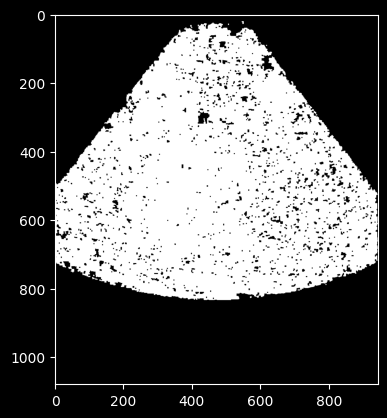

In [72]:
import cv2
import numpy as np

# Ruta al archivo de video

# Abrir el video
vidObj = cv2.VideoCapture(mp4_file_path)

# Configurar el tiempo inicial en el video (99 / FrameRate)
fps = vidObj.get(cv2.CAP_PROP_FPS)
start_time = 99 / fps
vidObj.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

# Leer el primer frame y convertirlo a escala de grises
ret, frame = vidObj.read()
if not ret:
    raise ValueError("No se pudo leer el frame inicial del video.")
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

diff = None

while True:
    # Leer el siguiente frame
    ret, frame2 = vidObj.read()
    if not ret:
        break
    
    # Convertir el frame a escala de grises
    frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    # Calcular la diferencia entre los frames
    diff = frame != frame2
    plt.imshow(diff, cmap='gray')
    
    # Procesar la diferencia: eliminar objetos pequeños y rellenar agujeros
    #diff = np.invert(diff.astype(np.uint8))  # Invertir para simular ~diff
    diff = cv2.morphologyEx(diff.astype(np.uint8), cv2.MORPH_OPEN, np.ones((3, 3), dtype=np.uint8))  # Simular eliminación de objetos pequeños
    diff = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, np.ones((3, 3), dtype=np.uint8))  # Rellenar agujeros
    plt.imshow(diff, cmap='gray')
    frame = frame2
    
    # Verificar la posición actual en el video
    current_time = vidObj.get(cv2.CAP_PROP_POS_MSEC) / 1000
    if current_time > 4 / fps:
        break

# Obtener los límites del área de interés
row_limits, col_limits = np.where(diff > 0)
y1, y2 = row_limits.min(), row_limits.max()
x1, x2 = col_limits.min(), col_limits.max()

print(f"Recorte de los límites: ({x1}, {y1}) a ({x2}, {y2})")

new_vid=gt_video[:,y1:y2,x1:x2,:]

First frame above threshold: 59
Last frame above threshold before returning: 631


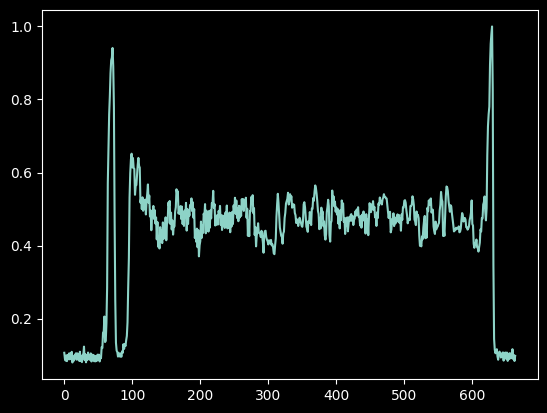

In [73]:
groundtruth = new_vid[:,:,:,0]
#diff between groundtruth matrix and groundtruth delayed 1 frame
diff = groundtruth[1:,:,:]-groundtruth[:-1,:,:]
#sum each frame of diff and plot pixel intensity vs frame
diff_sum = np.sum(diff,axis=(1,2))
#normalize diff_sum
diff_sum = diff_sum/np.max(diff_sum)
plt.plot(diff_sum)

# Assuming diff_sum is your normalized data array from the plot
# Example: diff_sum = np.array([...])  # Replace with your actual array
threshold = 0.2

# Detect indices where diff_sum crosses above the threshold
first_frame = np.where(diff_sum > threshold)[0][0]  # First upward crossing
last_frame = np.where(diff_sum > threshold)[0][-1]  # Last upward crossing (before drop)

# Print results
print("First frame above threshold:", first_frame)
print("Last frame above threshold before returning:", last_frame)

groundtruth=groundtruth[first_frame:last_frame,:,:]
#reshape to 512x512
#groundtruth=np.array([cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA) for img in groundtruth])
marika_002_1=marika_002_1[first_frame:last_frame,:,:]
maddie_002_1=maddie_002_1[first_frame:last_frame,y1:y2,x1:x2]

In [79]:
from skimage.transform import resize

print(marika_002_1.shape)
print(maddie_002_1.shape)
num_classes=2
# Crear la versión one-hot encoded para maddie_002_1
new_shape = groundtruth.shape[1:3]
maddie_002_1=np.array([resize(mask, new_shape, order=0, preserve_range=True, anti_aliasing=False) for mask in maddie_002_1])
one_hot_maddie = np.eye(num_classes)[maddie_002_1]  # Esto genera el one-hot encoding
# Verificar el nuevo shape
print(one_hot_maddie.shape)
#reshape marika_002_1 to match new_vid
new_shape = groundtruth.shape[1:3]
print(new_shape)
# Resize using nearest neighbor interpolation
marika_002_1 = np.array([resize(mask, new_shape, order=0, preserve_range=True, anti_aliasing=False) for mask in marika_002_1])

# Convert the resized mask to integers (categories)
marika_002_1 = marika_002_1.astype(int)

print(np.unique(marika_002_1))
# Supongamos que `marika_002_1` es tu array original con shape (696, 1053, 1219)
num_classes = 6  # Incluyendo la categoría faltante (5)

# Crear la versión one-hot encoded
one_hot = np.eye(num_classes)[marika_002_1]  # Esto genera el one-hot encoding
# Verificar el nuevo shape
print(one_hot.shape) 


(572, 815, 944)
(572, 813, 940)
(572, 813, 940, 2)
(813, 940)
[0 1 2 5]
(572, 813, 940, 6)


In [80]:
print(groundtruth.shape)
print(marika_002_1.shape)

(572, 813, 940)
(572, 813, 940)


In [81]:
import torchio as tio
# Create a TorchIO subject with paired data
subject = tio.Subject(
    video_gt=tio.ScalarImage(tensor=np.expand_dims(groundtruth,axis=0)),  # Add channel dimension
    label=tio.LabelMap(tensor=np.expand_dims(marika_002_1,axis=0))  # Add channel dimension
)

 #efine the resize transform
resize_transform = tio.transforms.Resize((256, 512,512))  # New shape: [frames, width, height]

# Apply the resize transform to the subject
resized_subject = resize_transform(subject)


# Extract resized video GT and label from the subject
resized_video_gt = resized_subject.video_gt.tensor.squeeze(0).numpy()  # Remove channel dimension
resized_label = resized_subject.label.tensor.squeeze(0).numpy().astype(int)  # Ensure integers for label

# Print shapes
print("Original GT shape:", groundtruth.shape)
print("Resized GT shape:", resized_video_gt.shape)
print("Original Label shape:", marika_002_1.shape)
print("Resized Label shape:", resized_label.shape)

Original GT shape: (572, 813, 940)
Resized GT shape: (256, 512, 512)
Original Label shape: (572, 813, 940)
Resized Label shape: (256, 512, 512)


In [82]:
# Crear la versión one-hot encoded
one_hot = np.eye(num_classes)[resized_label]  # Esto genera el one-hot encoding
# Verificar el nuevo shape
print(one_hot.shape) 

(256, 512, 512, 6)


In [83]:
groundtruth = resized_video_gt

In [84]:
import numpy as np
import cv2

# Supongamos que `groundtruth` y `one_hot_mask` son tus datos:
# - `groundtruth` tiene la forma (696, 1053, 1219)
# - `one_hot_mask` tiene la forma (696, 1053, 1219, 6)

# Definir los colores para las categorías (BGR para OpenCV)
colors = [
    (0, 0, 0),        # Negro para la categoría 0
    (0, 0, 255),      # Rojo para la categoría 1 heart
    (0, 255, 0),      # Verde para la categoría 2 cabeza
    (255, 0, 0),      # Azul para la categoría 3 abdomen
    (0, 255, 255),    # Amarillo para la categoría 4 chest
    (255, 0, 255)     # Magenta para la categoría 5 placenta
]

# Parámetros para el video
fps = 10  # Frames por segundo
output_video = "overlay_video8_7_r.avi"  # Nombre del archivo de salida
frame_size = (groundtruth.shape[2], groundtruth.shape[1])  # (ancho, alto)

# Crear el objeto de video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, frame_size)

# Función para asignar colores a las máscaras
def apply_colors(mask_combined, colors):
    # Crear una imagen en color basada en las categorías
    color_mask = np.zeros((mask_combined.shape[0], mask_combined.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        color_mask[mask_combined == i] = color
    return color_mask

# Generar cada frame
for i in range(groundtruth.shape[0]):  # Iterar sobre los frames (en la dimensión 0)
    # Obtener el frame de ground truth y la máscara
    gt_frame = groundtruth[i]  # Frame de groundtruth
    mask_frame = one_hot[i]  # Frame de la máscara (one-hot)

    # Combinar las categorías con los colores
    mask_combined = np.argmax(mask_frame, axis=-1)  # Reconstruir categorías
    colored_mask = apply_colors(mask_combined, colors)  # Asignar colores a las categorías

    # Normalizar el ground truth si es necesario (opcional)
    if gt_frame.max() > 1:
        gt_frame = gt_frame / gt_frame.max()

    # Convertir ground truth a un formato RGB
    gt_rgb = (np.stack([gt_frame] * 3, axis=-1) * 255).astype(np.uint8)

    # Combinar el ground truth con la máscara (alpha blending)
    overlay = cv2.addWeighted(gt_rgb, 0.5, colored_mask, 0.5, 0)

    # Escribir el frame en el video
    video_writer.write(overlay)

# Liberar el objeto de video
video_writer.release()
print(f"Video guardado como {output_video}")


Video guardado como overlay_video8_7_r.avi
